## ***Mount Drive***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ***Import Required Libs***

In [2]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

import torchvision.transforms.functional
from torchvision.utils import draw_segmentation_masks

import skimage
from skimage import data,io
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte


import numpy as np
import random

from pathlib import Path

from PIL import Image
import PIL

from pandas.core.common import flatten

from torchvision.transforms.functional import InterpolationMode


import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import os
import shutil
import time


from sklearn.neighbors import KNeighborsClassifier
import glob
from tqdm import tqdm

from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

from sklearn.metrics import classification_report

In [3]:
def get_train_val_list():
  filename = '/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/PascalVOC/PascalVOC/trainval/train.txt'
  train_list = []
  with open(filename) as file:
      while (line := file.readline().rstrip()):
        train_list.append(line)

  filename = '/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/PascalVOC/PascalVOC/trainval/val.txt'
  val_list = []
  with open(filename) as file:
      while (line := file.readline().rstrip()):
        val_list.append(line)

  return train_list, val_list

## ***Custom Dataset***

In [4]:
## Custom class for PASCALVOC dataset
class SegmentationDataset(torch.utils.data.Dataset):
  
  def __init__(self, root, mode, image_list = None, transforms=None):
    data_paths_images = root + '/Images'
    data_paths_segmented = root + '/Annotations'
    image_paths = [] #to store image paths in list
    segmented_paths = [] #to store image annotation paths in list

    if mode == 'test':
      for data_path in glob.glob(data_paths_images + '/*'):
        file_path = Path(data_paths_segmented + '/' + data_path.split('/')[-1].split('.')[0] + '.png')
        if (file_path.is_file()):
          segmented_paths.append(data_paths_segmented + '/' + data_path.split('/')[-1].split('.')[0] + '.png')
          image_paths.append(data_path)

    else:
      for name in image_list:
        segmented_paths.append(data_paths_segmented + '/' + name + '.png')
        image_paths.append(data_paths_images + '/' + name + '.jpg')

    image_paths = list(flatten(image_paths))
    segmented_paths = list(flatten(segmented_paths))

    self.image_paths = image_paths
    self.segmented_paths = segmented_paths
    self.transforms = transforms

  def __len__(self):
    return len(self.image_paths)
  
  def __getitem__(self, idx):
    image_filepath = self.image_paths[idx]
    segmented_image_filepath = self.segmented_paths[idx]

    image = Image.open(image_filepath).convert('RGB')
    segmented_image = Image.open(segmented_image_filepath)

    if self.transforms is not None:
      image = self.transforms(image)
    resize_transform = transforms.Resize((520, 520), interpolation=InterpolationMode.NEAREST)
    convert_tensor = transforms.PILToTensor()
    segmented_image = resize_transform(convert_tensor(segmented_image))

    return image, segmented_image

## ***Data Transforms***

In [5]:
##Data Transforms for train, test and val datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((520,520)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((520,520)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((520,520)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## ***Data Loaders***

In [6]:
##Preparing datasets
train_list, val_list = get_train_val_list()
train_set = SegmentationDataset('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/PascalVOC/PascalVOC/trainval', 'train', train_list, data_transforms['train'])
val_set = SegmentationDataset('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/PascalVOC/PascalVOC/trainval', 'val', val_list, data_transforms['val'])
test_set = SegmentationDataset('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/PascalVOC/PascalVOC/test', 'test', transforms = data_transforms['test'])

##dicts for train, val, test sets
image_datasets = {'train':train_set , 'val': val_set, 'test': test_set}
shuffle_datasets = {'train': True, 'val': True, 'test': False}

##Creating dataloader for train, val, test sets
dataloaders = { x : torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = shuffle_datasets[x], num_workers = 2) for x in ['train', 'val', 'test'] }

##Setting device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/PascalVOC/PascalVOC/test/Images/000584.jpg
[  0   2  18 255]


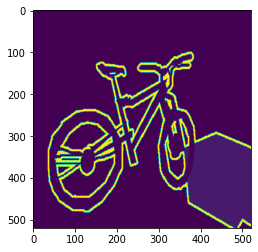

In [7]:
## Visualizing masks in train_Set
img2, img = test_set[58]
# print(img2.dtype)
print(test_set.image_paths[58])
img1 = torch.squeeze(img).numpy()
print(np.unique(img1))
plt.imshow(img1)

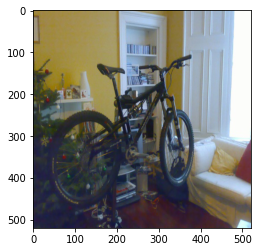

In [8]:
## Visualizing image in train_set
_ = img2.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * _ + mean
inp = np.clip(inp, 0, 1)
plt.imshow(inp)

## ***Label Map***

In [9]:
### Color encoding for classes in PASCAL VOC dataset
label_map = [
               (0, 0, 0),  # background
               (128, 0, 0), # aeroplane
               (0, 128, 0), # bicycle
               (128, 128, 0), # bird
               (0, 0, 128), # boat
               (128, 0, 128), # bottle
               (0, 128, 128), # bus 
               (128, 128, 128), # car
               (64, 0, 0), # cat
               (192, 0, 0), # chair
               (64, 128, 0), # cow
               (192, 128, 0), # dining table
               (64, 0, 128), # dog
               (192, 0, 128), # horse
               (64, 128, 128), # motorbike
               (192, 128, 128), # person
               (0, 64, 0), # potted plant
               (128, 64, 0), # sheep
               (0, 192, 0), # sofa
               (128, 192, 0), # train
               (0, 64, 128) # tv/monitor
]

## ***Functions for Data Visualization***

In [10]:
## Function to map label to correspoding color maps
def labelmap_to_image(labels):
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)
    
    for label_num in range(0, len(label_map)):
        index = labels == label_num
        red_map[index] = np.array(label_map)[label_num, 0]
        green_map[index] = np.array(label_map)[label_num, 1]
        blue_map[index] = np.array(label_map)[label_num, 2]
        
    image = np.stack([red_map, green_map, blue_map], axis=2)

    return image

In [11]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [12]:
## Function used to visualize model output, ground_truth and their difference
def draw_segmentation_map(inps, outputs, ground_truth=None):

    inps = inps.detach().cpu()
    inps = invTrans(inps).numpy().transpose((1,2,0))

    outputs = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    segmented_image = labelmap_to_image(outputs)
    

    
    if(ground_truth is not None):
      fig, axs = plt.subplots(ncols=4, squeeze=False, figsize=(30, 30))
      axs[0,0].title.set_text('Original Image')
      axs[0,1].title.set_text('Segmented Image')
      axs[0,2].title.set_text('Ground Truth Image')
      axs[0,3].title.set_text('Difference of Original and ground truth Image')
      axs[0,0].imshow(inps)
      axs[0, 1].imshow(segmented_image)
      ground_truths = labelmap_to_image(ground_truth)
      diff_image = segmented_image - ground_truths
      axs[0, 2].imshow(ground_truths)
      axs[0,3].imshow(diff_image)
    
    else:
      fig, axs = plt.subplots(ncols=2, squeeze=False, figsize=(30, 30))
      axs[0,0].title.set_text('Original Image')
      axs[0,1].title.set_text('Segmented Image')
      axs[0,0].imshow(inps)
      axs[0, 1].imshow(segmented_image)
      
    return segmented_image

## ***Pixel Accuracy***

In [13]:
## Function to get pixel accuracy fro each image
def get_pixel_accuracy(output, ground_truth):
  output = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()
  matching_pixels = np.sum(output == ground_truth)
  total_pixels = ground_truth.shape[0]*ground_truth.shape[1]

  pixel_accuracy = matching_pixels/total_pixels
  # print(pixel_accuracy*100)
  return pixel_accuracy

## ***M-IOU***

In [14]:
## Function to get miou for each image
def get_miou(output, ground_truth):
    output = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()
    num_categories = len(weights.meta["categories"])

    total_iou = 0

    for label_num in range(num_categories):
      category_map = np.ones_like(ground_truth).astype(np.uint8)*label_num
      intersection_map = np.logical_and(output == category_map, ground_truth == category_map)
      union_map = np.logical_or(output == category_map, ground_truth == category_map)
      if(np.sum(union_map) == 0) :
        iou_category = 1
      else:
        iou_category = np.sum(intersection_map) / np.sum(union_map)
      total_iou += iou_category

    miou = total_iou / num_categories

    return miou

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    model.to(device)
    with torch.no_grad():
        for images, labels in dataloaders['test']:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            outs = outputs['out']
            for j in range(images.size()[0]):
                draw_segmentation_map(images[j], outs[j],torch.squeeze(labels[j]).cpu().numpy())
        
            return

## ***Model Initialization***

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


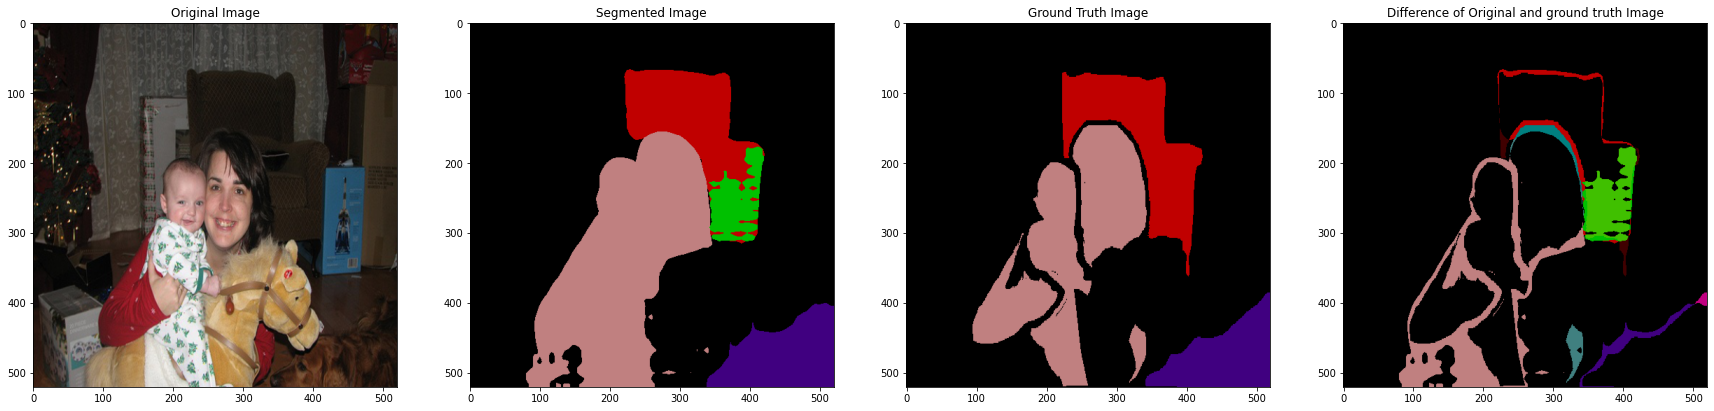

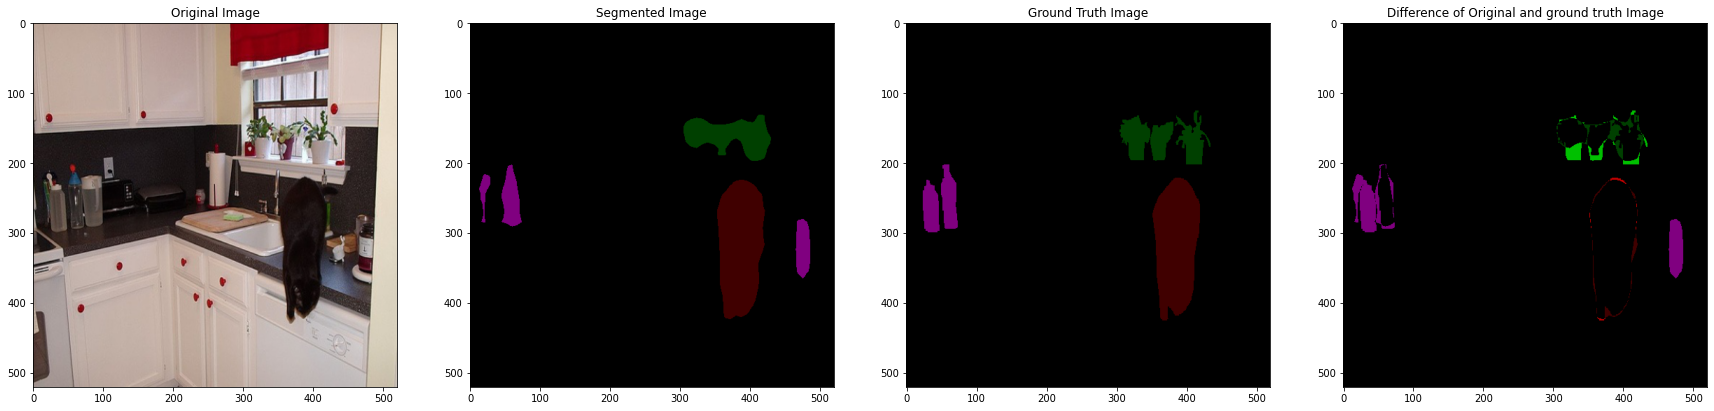

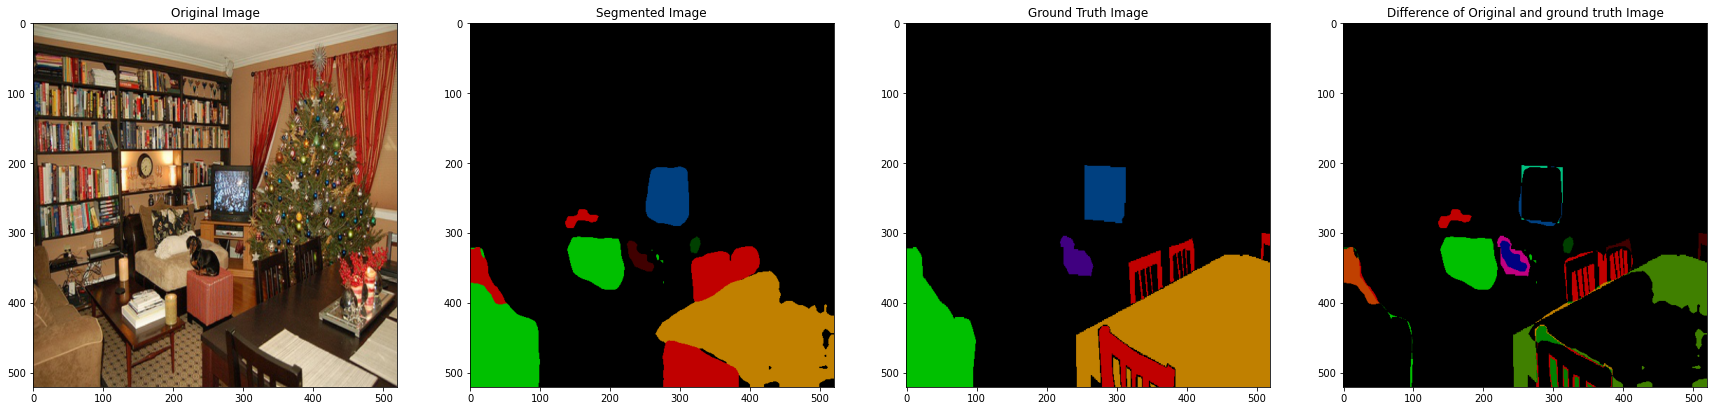

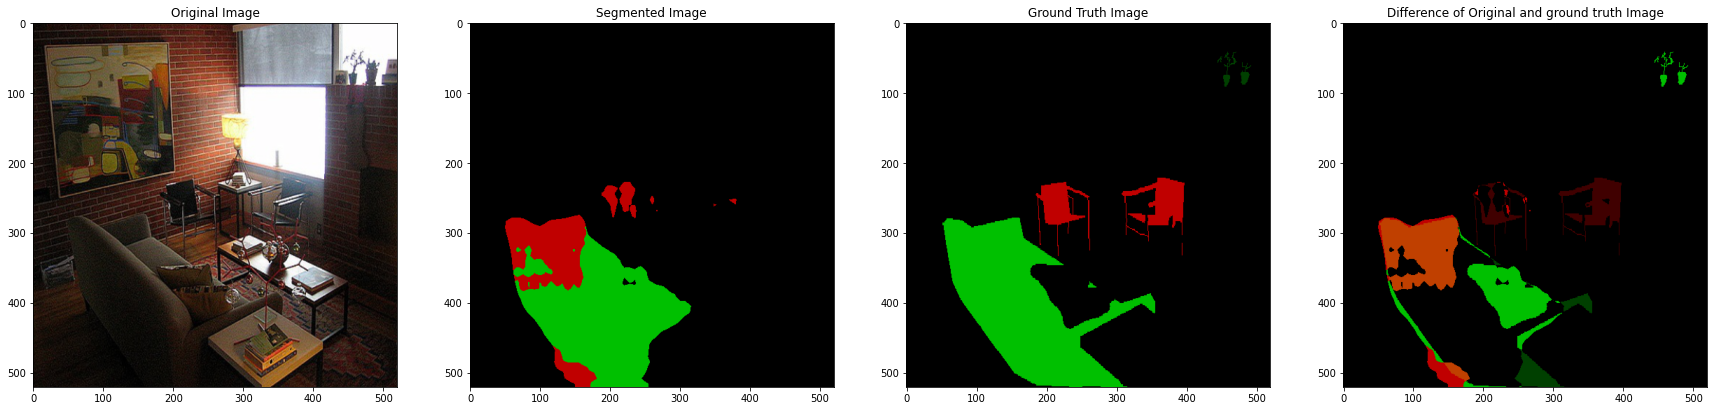

In [16]:
weights = FCN_ResNet50_Weights.DEFAULT

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

visualize_model(model, 4)

## ***Test Model***

In [17]:
def test_model(model):
  model.to(device)
  model.eval()
  pixel_accuracies = []
  miou = []
  with torch.no_grad():
      for images, masks in dataloaders['test']:
          images = images.to(device)
          masks = masks.to(device)

          outputs = model(images)
          outs = outputs['out']

          for j in range(images.size()[0]):
              pixel_accuracies.append(get_pixel_accuracy(outs[j],torch.squeeze(masks[j]).cpu().numpy()))
              miou.append(get_miou(outs[j],torch.squeeze(masks[j]).cpu().numpy()))

  pixel_accuracy = np.array(pixel_accuracies).mean()
  miou_acc = np.array(miou).mean()

  print("Pixel Accuracy - {}".format(pixel_accuracy*100))
  print("MIOU -  {}".format(miou_acc*100))

  return pixel_accuracy, miou_acc 

### **Model Accuracy**

In [18]:
model = fcn_resnet50(weights=weights, progress=False)
pixel_acuuracy, miou = test_model(model)

Pixel Accuracy - 87.92256797689491
MIOU -  92.14278211168683


In [19]:
def visualize_model_image(model, image):
    was_training = model.training
    model.eval()
    model.to(device)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    with torch.no_grad():
      images = transform(image)
      images = torch.unsqueeze(images,dim = 0)
      images = images.to(device, dtype = torch.float)
      outputs = model(images)
      outs = outputs['out']
      draw_segmentation_map(images.squeeze(), outs)

      return

## ***Visualizing Test Images***

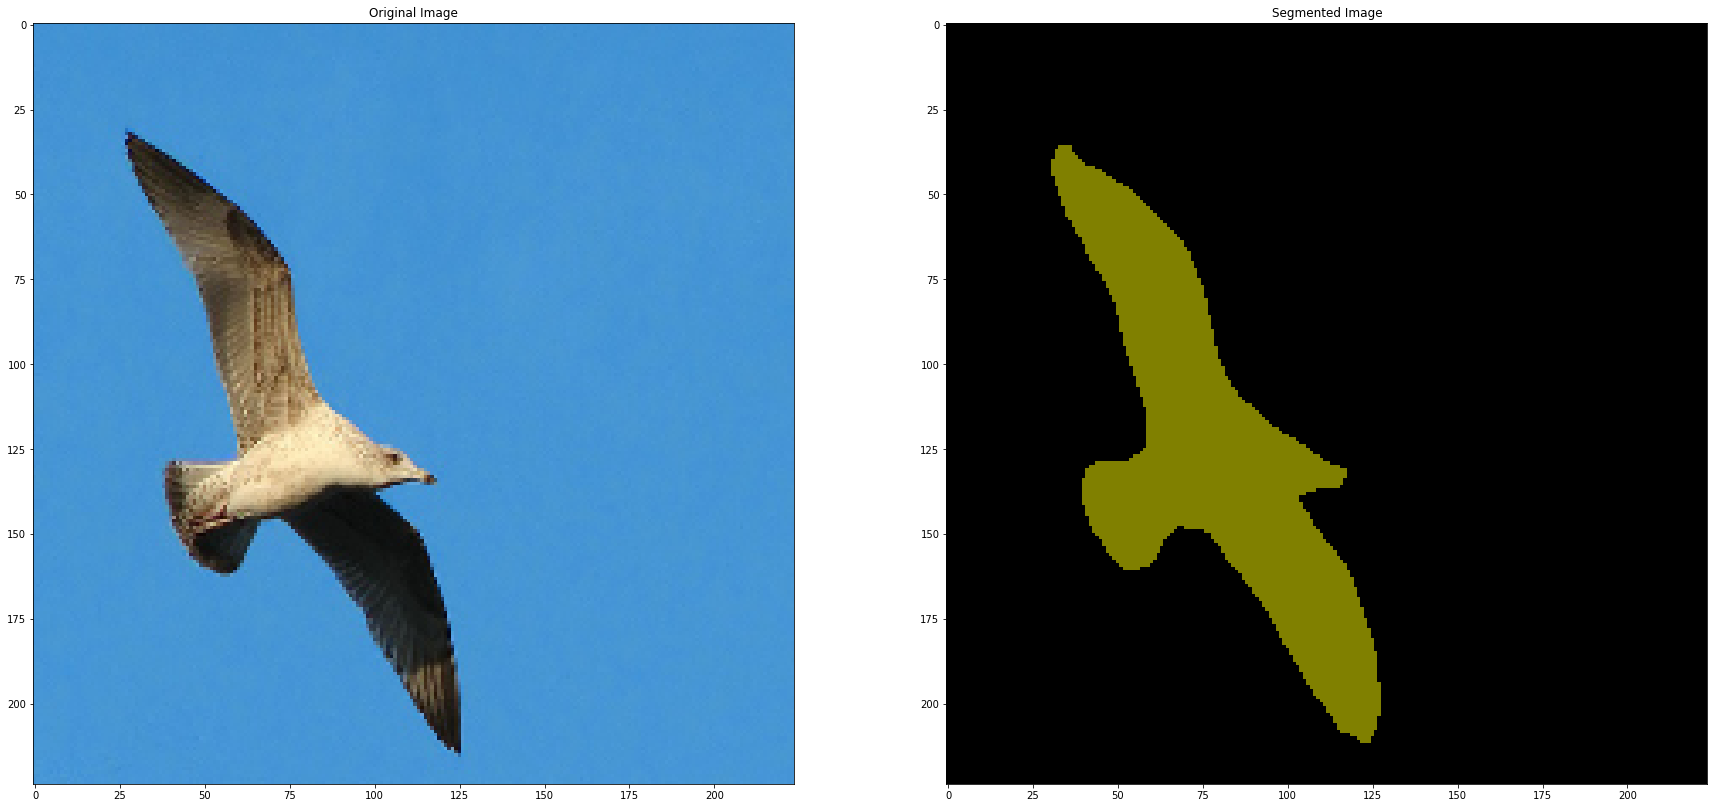

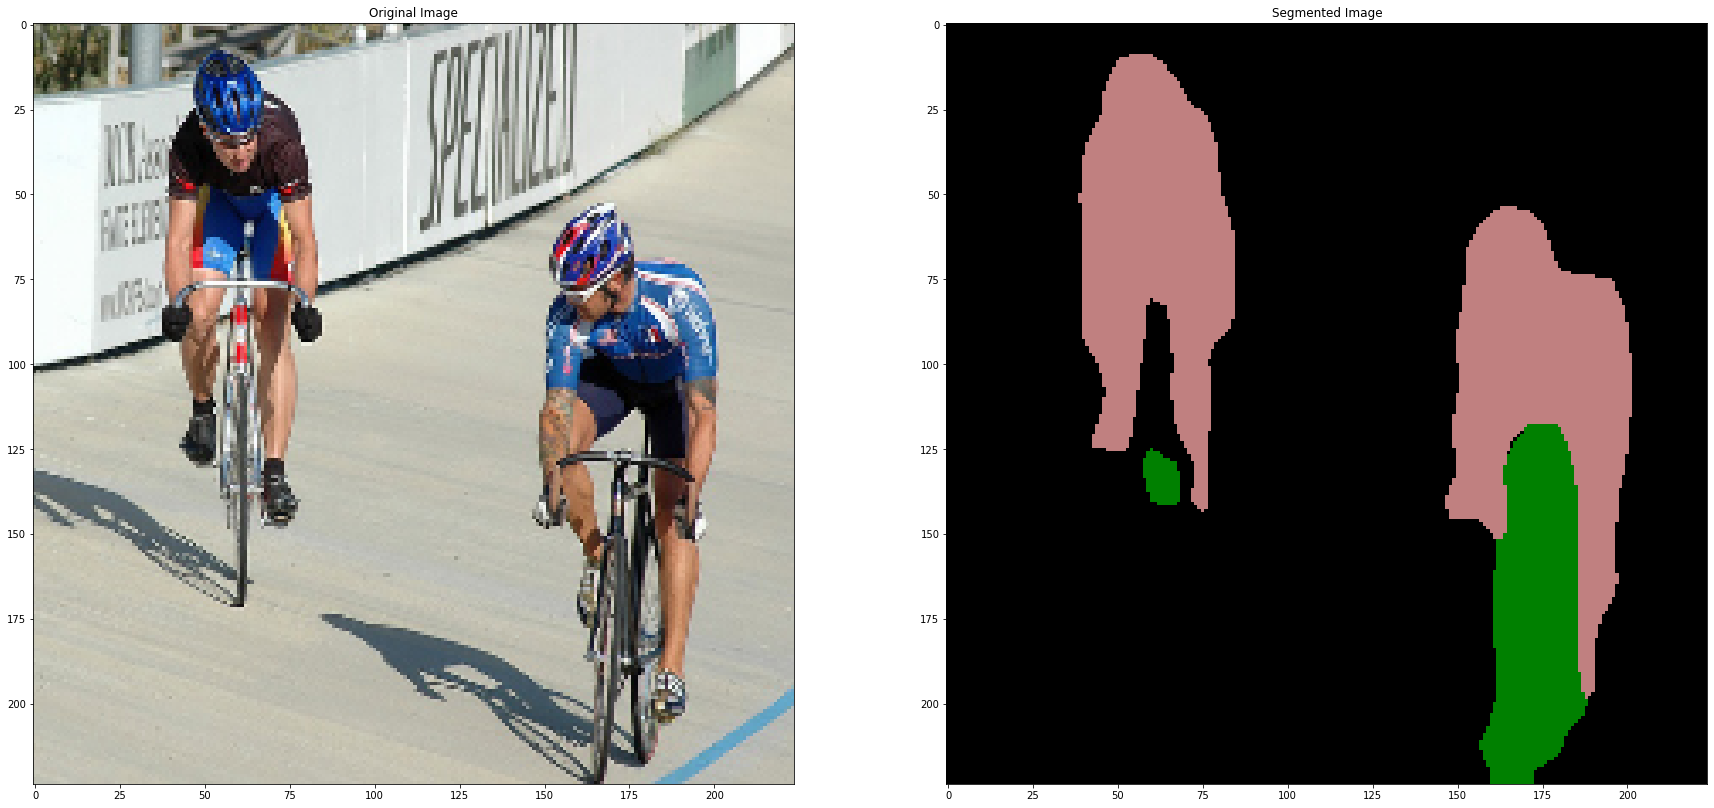

In [20]:
img_test_4 = Image.open('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images/test4.jpg').convert('RGB')
img_test_5 = Image.open('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images/test5.jpg').convert('RGB')

visualize_model_image(model, img_test_4)
visualize_model_image(model, img_test_5)

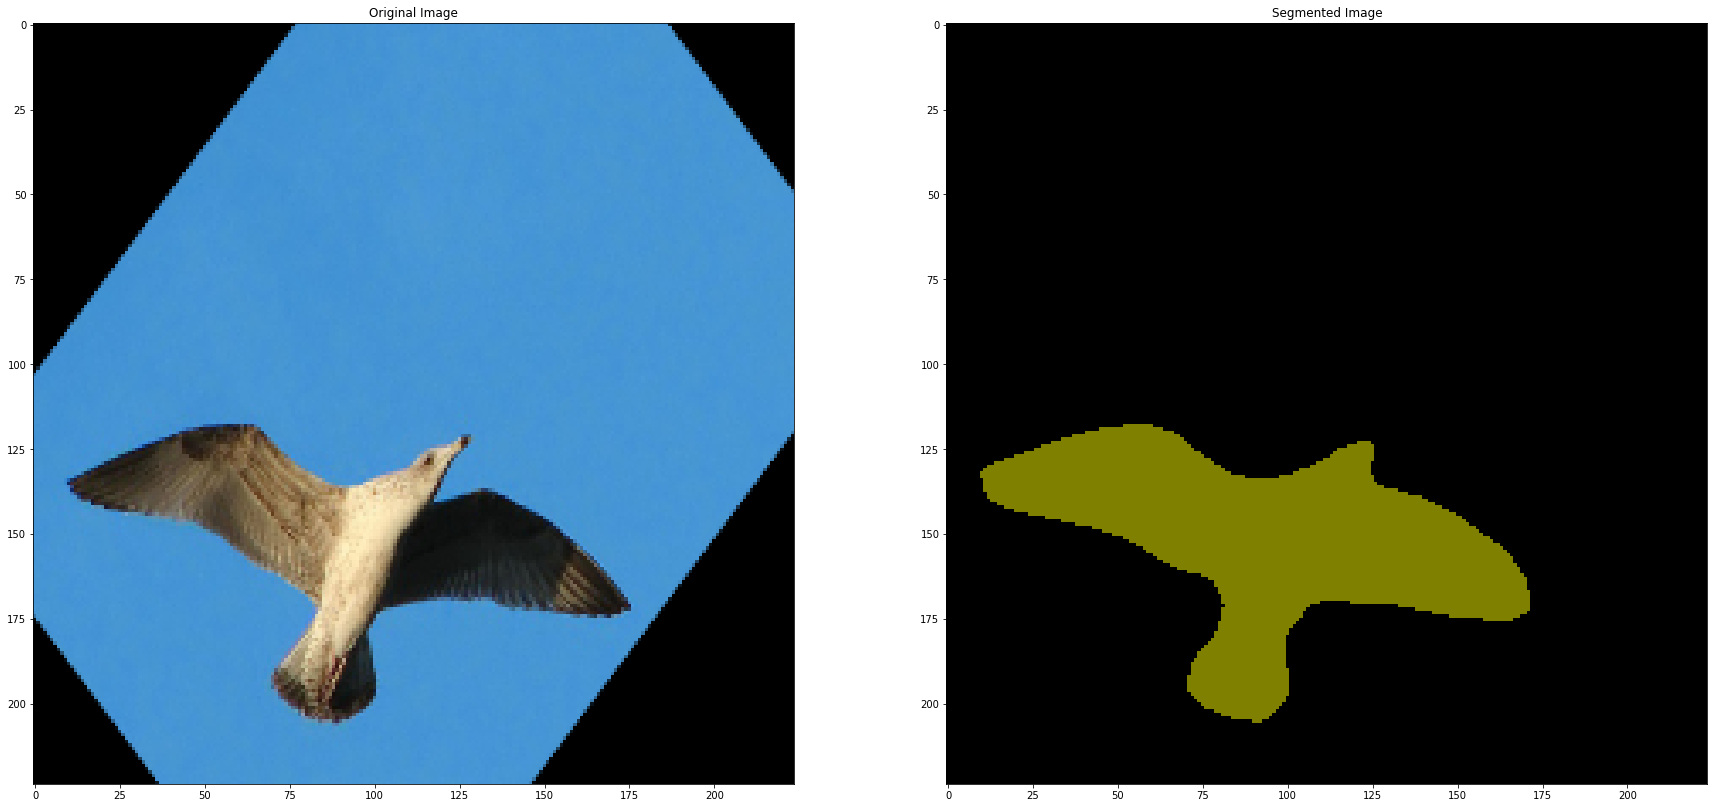

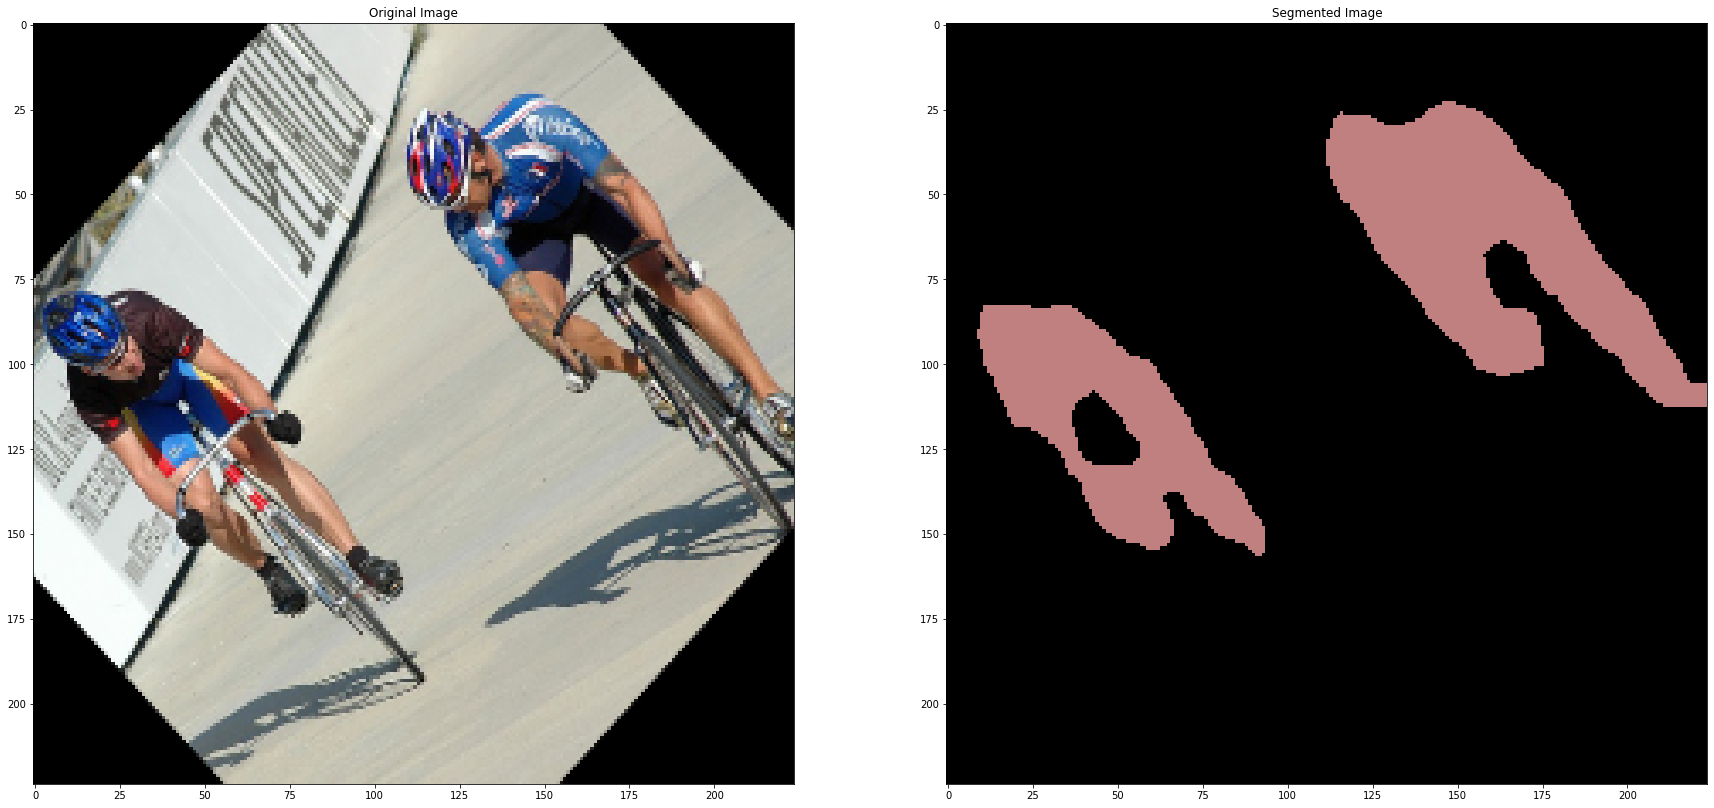

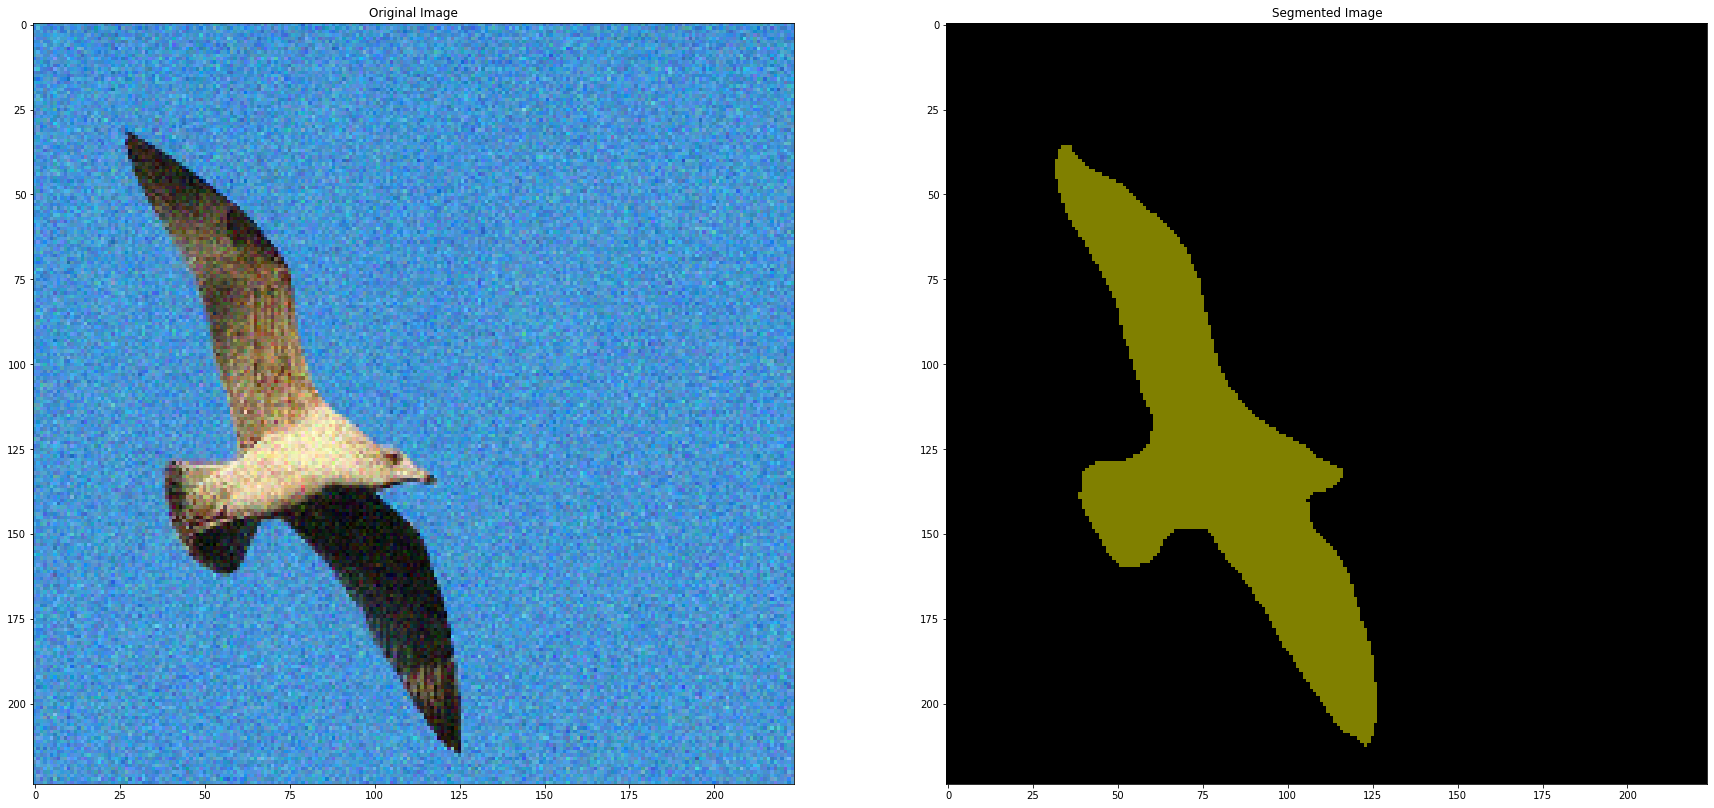

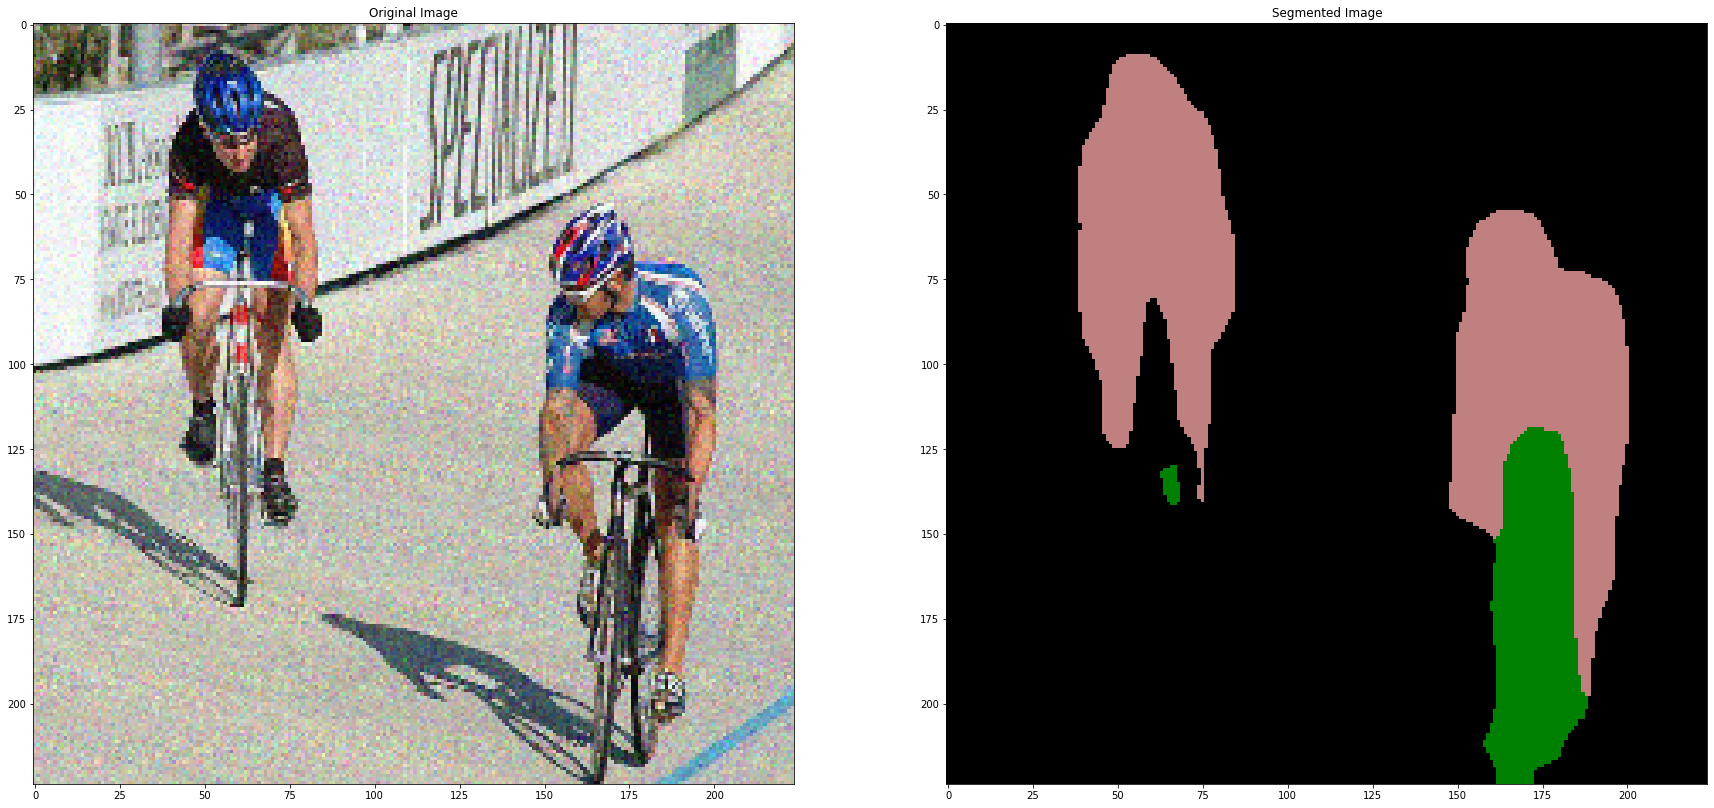

In [21]:
Ncut_data_dir = '/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images'
load_pattern = os.path.join(Ncut_data_dir, '*jpg') + ':' + os.path.join(Ncut_data_dir, '*png')
test_images = io.imread_collection(load_pattern)

eagle = test_images[3]
cycle = test_images[4]
eagle_rotated = skimage.transform.rotate(eagle, 45)
cycle_rotated = skimage.transform.rotate(cycle, 45)
eagle_noisy = skimage.util.random_noise(eagle, mode='gaussian')
cycle_noisy= skimage.util.random_noise(cycle, mode='gaussian')

visualize_model_image(model, eagle_rotated)
visualize_model_image(model, cycle_rotated)

visualize_model_image(model, eagle_noisy)
visualize_model_image(model, cycle_noisy)
